## Reading generated images

In [1]:
import io
import cv2
import json
import time
import requests
import numpy as np
from matplotlib import pyplot as plt
from random import sample as samp
from IPython.display import clear_output
from lib.util import to_ai_url, setup_plt
from lib.load import index_urls, gen_images
from lib.util import setup_viz_box, draw_viz_box
from lib.truth import to_truth
from lib.ai import gen_results
from lib.stats import to_ious

USE_AWS_AI = False

print("testing", "on aws" if (USE_AWS_AI) else "locally")
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["figure.dpi"] = 40


testing locally


In [2]:
NUM_READ = -1 # Unlimited
NUM_READ = 5 # TODO

images = []
sources = index_urls('merged.json', NUM_READ)
print(f'Loading ≤ {NUM_READ} images...')
image_gen = gen_images(sources)

for src in sources:
    img = None
    try: img = next(image_gen)
    except StopIteration: break
    images.append(img)
    if len(images) % 10 == 0:
        clear_output(wait=True)
        print(round(100*len(images)/len(sources)),'%')

print('Loaded', len(images), 'images!')

Loading ≤ 5 images...
Loaded 5 images!


## OCR

In [3]:
try: images
except NameError:
    raise(Exception("Please run prior cell"))
try: USE_AWS_AI
except NameError:
    raise(Exception("Please run first cell"))

results = []
for res in gen_results(USE_AWS_AI, images):
    results.append(res)
    clear_output(wait=True)
    print(round(100*len(results)/len(images)),'%')

100 %
Done with classifier and OCR!


## Visualization

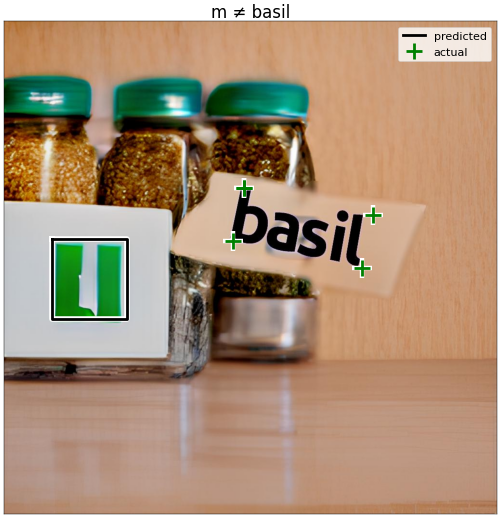

DONE


In [4]:
try: sources and images and results
except NameError:
    raise(Exception("Please run prior cells"))

N_VIZ = 5
DELAY_VIZ = 1.0

truth = to_truth(sources)
samples = list(zip(truth, images, results))
print(f'sample size: {len(samples)}')

for (i, (real, img, res)) in enumerate(samples):
    res_text = res["ocr_all_results"][0]["text"]
    res_box = res["ocr_all_results"][0]["box"]
    rea_text = real["text"]
    rea_box = real["box"]
    if (i >= N_VIZ): continue
    time.sleep(DELAY_VIZ)
    setup_plt()
    clear_output(wait=True)
    plt.imshow(img)

    # Title to viz box plot
    viz_setup = setup_viz_box(res_text, rea_text)

    # Draw predicted bounding boxes
    draw_viz_box('predicted', [res_box], viz_setup["predicted"])

    draw_viz_box('actual', rea_box, viz_setup["actual"])
        
    plt.legend(fontsize = 20)
    plt.show()
print('DONE')


# Evaluation

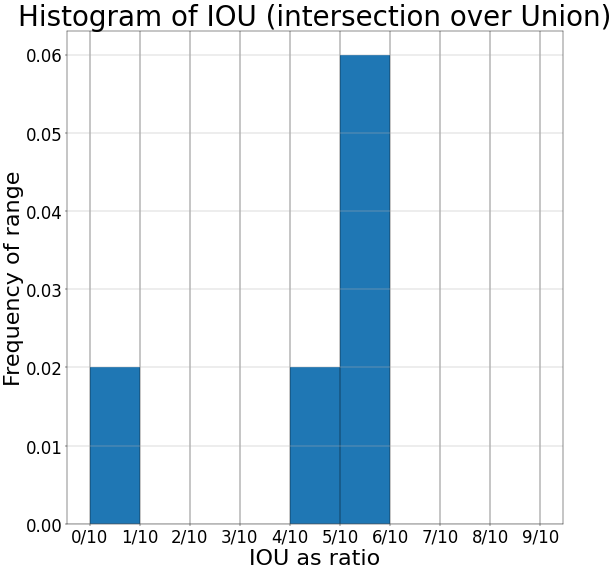

In [5]:
try: images and truth and results
except NameError:
    raise(Exception("Please run prior cells"))
    
ious = to_ious(images, truth, results)

setup_plt(True)
bin_range = list(range(0,100,10))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(ious, bins = bin_range, density = True)
plt.title(f'Histogram of IOU (intersection over Union)', fontsize = 50)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x//10}/10' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("IOU as ratio", fontsize=40)
plt.ylabel("Frequency of range", fontsize=40)
plt.show() # TODO
    

In [6]:
try: ious
except NameError:
    raise(Exception("Please run prior cell"))
    
MEAN_IOU = np.mean(ious)

TEXT_EQUALITY = [a["text"] == b['ocr_all_results'][0]["text"] for (a, b) in zip(truth, results)]
TEXT_ACCURACY = int(np.array(TEXT_EQUALITY, dtype=bool).sum())/len(TEXT_EQUALITY)
MEAN_CORRECT_IOU = np.mean(np.array(ious)[TEXT_EQUALITY])

print(f'{round(MEAN_IOU, 3)}% mean IOU')
print(f'   {round(MEAN_CORRECT_IOU, 3)}% for true predictions')
print(f'\n{round(TEXT_ACCURACY*100, 3)}% text accuracy')

43.0% mean IOU
   53.75% for true predictions

80.0% text accuracy


In [7]:
try: TEXT_EQUALITY and results
except NameError:
    raise(Exception("Please run prior cell"))

N_GPT = 5
DELAY_GPT = 5.0

ai_server_url = to_ai_url(USE_AWS_AI)
print(f'Using Custom AI: {ai_server_url}')

#api request instructions
def chat_with_gpt(spices):
    endpoint = f'{ai_server_url}recipe'
    response = requests.post(endpoint, json.dumps({
        "spices": spices
    }))
    res_data = response.json()
    return res_data
  
found_spices = set([v['ocr_all_results'][0]["text"] for (t,v) in zip(TEXT_EQUALITY, results) if t])
spice_lists = [samp(list(found_spices),samp([2,3,4],1)[0]) for _ in range(N_GPT)]
    
for spices in spice_lists:
    clear_output(wait=True)
    print('INPUT SPICES:')
    print('-', ', '.join(spices))
    output = chat_with_gpt(spices)
    print('\nOUTPUT RECIPE:')
    print(f'{len(output["spices"]) - len(spices)} added spices')
    print(f'{len(output["ingredients"])} added ingredients')
    print()
    print(output["text"])
    time.sleep(DELAY_GPT)
    print('\n')

INPUT SPICES:
- allspice, baharat, ancho

OUTPUT RECIPE:
2 added spices
8 added ingredients

Title: Ancho Chili BBQ Rub
Spices: allspice, baharat, ancho, chili, paprika
Ingredients: 2 tablespoons ancho chili powder, 1 tablespoon paprika, 1 teaspoon baharat, 1 teaspoon allspice, 1 teaspoon garlic powder, 1 teaspoon onion powder, 1 teaspoon black pepper, 1 teaspoon sea salt


